In [5]:
from fsl_mrs.utils import mrs_io
import numpy as np
from matplotlib import pyplot as plt
import ants

In [19]:
lcmodel_raw = np.loadtxt('/home/malte/Documents/Projects/dMRS_starting_data_cristina/CristinasTestData/TheirFolder/Data/NotToShare/quantified/SUM_Bruker_2022-10-31_22_1_ser_processed.lcm/SUM_Bruker_2022-10-31_22_1_ser_processed.RAW',
                        skiprows=7)

In [22]:
lcmodel_raw.shape

(4096, 2)

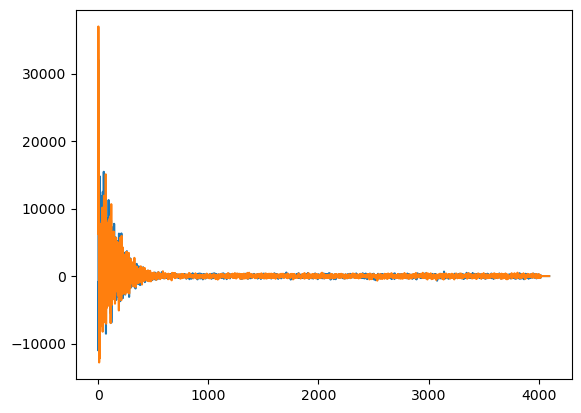

In [20]:
plt.plot(lcmodel_raw)

In [15]:
fsl_mrs_obj = mrs_io.read_FID('/home/malte/Documents/Projects/dMRS_starting_data_cristina/CristinasTestData/derivatives/preprocessed/sub-01/ses-01/dmrs/sub-01_ses-01_dmrs_lowb.nii.gz')

In [16]:
fsl_mrs_data = fsl_mrs_obj.image.data[0,0,0]

(0.0, 100.0)

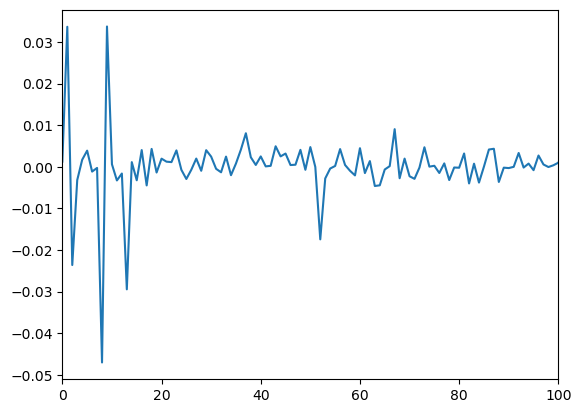

In [30]:
plt.plot(np.imag(fsl_mrs_data)-lcmodel_raw[:,1])
plt.xlim(0,100)

(0.0, 100.0)

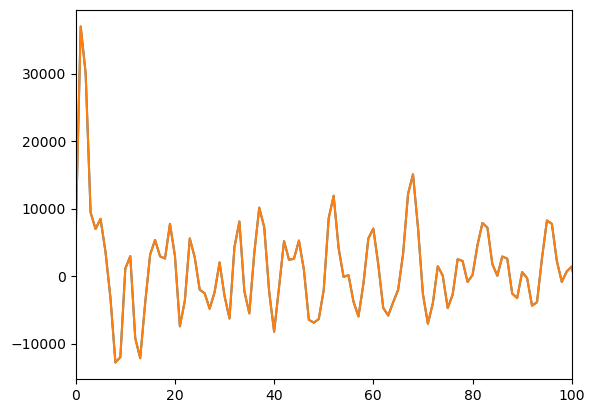

In [31]:
plt.plot(np.imag(fsl_mrs_data))
plt.plot(lcmodel_raw[:,1])
plt.xlim(0,100)

In [32]:
fsl_mrs_obj.bandwidth

7142.85714285714